In [34]:
import numpy as np
import tensorflow as tf


class Autoencoder(object):

    def __init__(self, n_layers, transfer_function=tf.nn.softplus, optimizer=tf.train.AdamOptimizer()):
        self.n_layers = n_layers
        self.transfer = transfer_function

        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_layers[0]])
        self.hidden_encode = []
        h = self.x
        for layer in range(len(self.n_layers)-1):
            h = self.transfer(
                tf.add(tf.matmul(h, self.weights['encode'][layer]['w']),
                       self.weights['encode'][layer]['b']))
            self.hidden_encode.append(h)

        self.hidden_recon = []
        for layer in range(len(self.n_layers)-1):
            h = self.transfer(
                tf.add(tf.matmul(h, self.weights['recon'][layer]['w']),
                       self.weights['recon'][layer]['b']))
            self.hidden_recon.append(h)
        self.reconstruction = self.hidden_recon[-1]

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)


    def _initialize_weights(self):
        all_weights = dict()
        initializer = tf.contrib.layers.xavier_initializer()
        # Encoding network weights
        encoder_weights = []
        for layer in range(len(self.n_layers)-1):
            w = tf.Variable(
                initializer((self.n_layers[layer], self.n_layers[layer + 1]),
                            dtype=tf.float32))
            b = tf.Variable(
                tf.zeros([self.n_layers[layer + 1]], dtype=tf.float32))
            encoder_weights.append({'w': w, 'b': b})
        # Recon network weights
        recon_weights = []
        for layer in range(len(self.n_layers)-1, 0, -1):
            w = tf.Variable(
                initializer((self.n_layers[layer], self.n_layers[layer - 1]),
                            dtype=tf.float32))
            b = tf.Variable(
                tf.zeros([self.n_layers[layer - 1]], dtype=tf.float32))
            recon_weights.append({'w': w, 'b': b})
        all_weights['encode'] = encoder_weights
        all_weights['recon'] = recon_weights
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict={self.x: X})

    def transform(self, X):
        return self.sess.run(self.hidden_encode[-1], feed_dict={self.x: X})

    def generate(self, hidden=None):
        if hidden is None:
            hidden = np.random.normal(size=self.weights['encode'][-1]['b'])
        return self.sess.run(self.reconstruction, feed_dict={self.hidden_encode[-1]: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict={self.x: X})

    def getWeights(self, depth=0):
        W = self.weights['encode'][depth]["w"]
        return self.sess.run(W)

    def getBiases(self):
        raise NotImplementedError
        return self.sess.run(self.weights)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


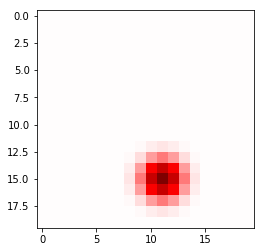

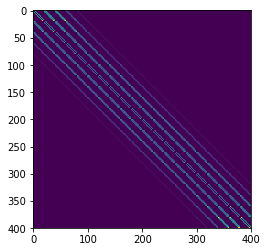

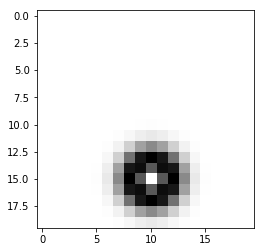

(400, 400)


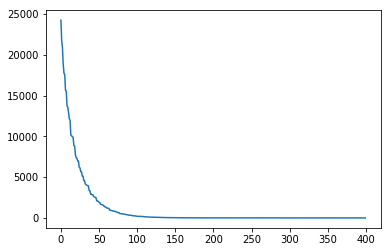

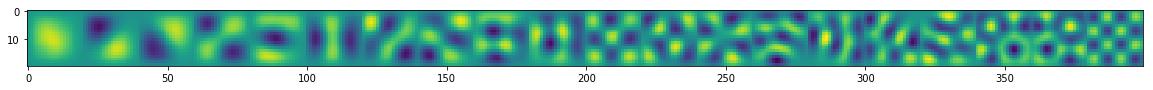

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from htmresearch.support.gridcells.grids_from_pca.utils import (gaussian_encoder,
                                                                create_random_walk_from_transition_fct,
                                                                transition_from_matrix,
                                                                create_transition_matrix)
from scipy.special import expit as sigmoid
%matplotlib inline

%load_ext autoreload
%autoreload 2



n_ = 20
n  = n_**2

wrap = False

T      = create_transition_matrix(n_, wrap, sigma=.7, with_diagonal=False)
tr_fct = transition_from_matrix(T)
enc    = gaussian_encoder((n_,n_), wrap, sigma = 3.)



X = create_random_walk_from_transition_fct(tr_fct, enc, n, 100000)
# mean = np.mean(X, axis=0, keepdims=True)
# print np.amin(mean), np.amax(mean)


# X = X - mean

    

plt.imshow(X[0].reshape((n_,n_)), cmap="seismic", vmin=-1, vmax=1)
plt.show()


plt.imshow(T)
plt.show()
plt.imshow(T[310].reshape((n_,n_)), cmap="binary")
plt.show()


# plt.imshow(mean.reshape((n_,n_)))
# plt.show()

# mean2 = np.mean(X, axis=0, keepdims=True)
# print np.amin(mean2), np.amax(mean2)
# plt.imshow(mean2.reshape((n_,n_)))
# plt.show()

G = np.dot(X.T,X)

lam, vec = np.linalg.eigh(G)
sorted_indices = np.argsort(lam)[::-1]
lam = lam[sorted_indices]
vec = vec[:, sorted_indices].T
print vec.shape
plt.plot(lam)
plt.show()

img = np.concatenate( [vec[i].reshape((n_,n_)) for i in range(0,20)], axis = 1)


plt.figure(figsize=(20,5))
plt.imshow(img)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(100000, 2)
(100000,)
(100000, 400)


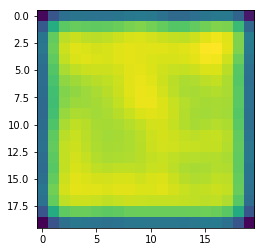

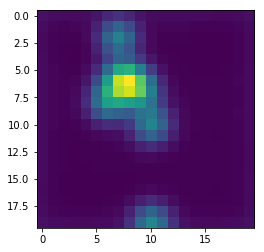

(400,)


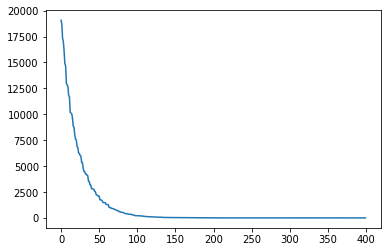

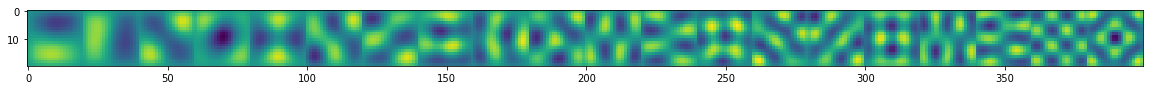

In [3]:

from htmresearch.support.gridcells.random_walk import smooth_torus_walk
%load_ext autoreload
%autoreload 2





# ------------------------
# Computing the torus walk
# ------------------------

Z, V = smooth_torus_walk(100000, start=[0.5,0.5], min_speed=0.3, max_speed=0.3, sigma=0.2)

print Z.shape

X_ = (Z*n_).astype(int)
X_ = X_[:,0]*n_ + X_[:,1] 

print X_.shape

X = np.zeros((len(X_), n) )
for t in range(len(X_)):
    X[t] = enc(X_[t])

mean = np.mean(X, axis=0, keepdims=True)    

X = X - mean
print X.shape
plt.imshow(mean.reshape((n_,n_)))
plt.show()
plt.imshow(sum([ x.reshape((n_,n_)) for x in X[:7]   ]))
plt.show()

G = np.dot(X.T,X)

lam, vec = np.linalg.eigh(G)
sorted_indices = np.argsort(lam)[::-1]
lam = lam[sorted_indices]
vec = vec[:, sorted_indices].T


print lam.shape

plt.plot(lam)
plt.show()

img = np.concatenate( [vec[i].reshape((n_,n_)) for i in range(0,20)], axis = 1)


plt.figure(figsize=(20,5))
plt.imshow(img)
plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


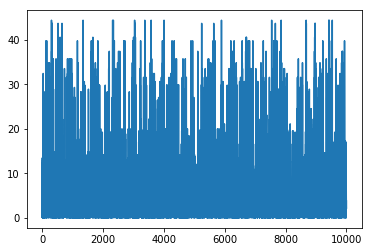

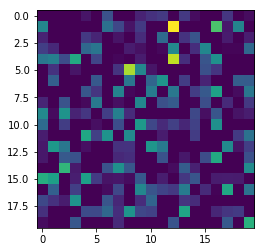

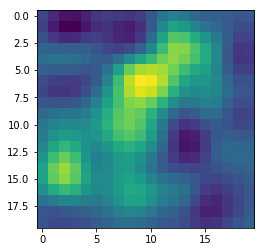

In [282]:

from htmresearch.support.gridcells.grids_from_pca.utils import (oja_w1, oja, mca)

G = np.dot(X.T,X)
W = np.random.randn(1,n)

i = 0

l = []
for epoch in range(20):
    print epoch
#     perm = np.random.permutation(len(X))
#     l = l + oja_w1(W, (X)[:100000], 0.001, False)
    l = l + mca(W, (X[:])[:100000], 0.00000001, True)

plt.plot(l[-10000:-1])
plt.show()
    
imgs = [W[i].reshape((n_,n_)) for i in range(W.shape[0])]
img = np.concatenate( imgs, axis = 1)

# plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

G_imgs = [ np.dot(G,img.reshape((n,1))).reshape((n_,n_)) for img in imgs ]

plt.imshow(np.concatenate( G_imgs, axis = 1))
plt.show()


(1, 400) (100000, 400)


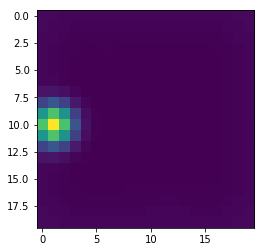

(100000, 400) (100000, 1)
(100000, 400)


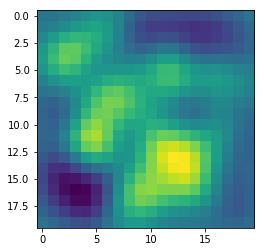

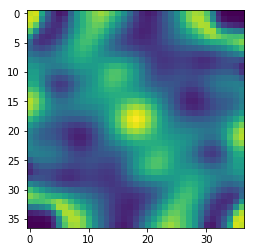

In [281]:
from htmresearch.support.gridcells.utils import (cross_correlate)
from scipy.special import expit as sigmoid

print W.shape, X.shape
X_ = X[:]
Y  = np.dot(W, X_.T ) 

# X_ = (X_ >= np.amax(X_, axis=1, keepdims=True)).astype(float)

# X_ = X.copy()

plt.imshow(X_[0].reshape((n_,n_)))
plt.show()

print X_.shape, Y.T.shape

heat = Y.T*X_
print heat.shape
heat = np.mean(heat, axis=0)


heat = (heat).reshape((n_,n_))



# pad = 5
# left  = heat[pad:-pad,pad:-pad]
left  = heat
right = left

plt.imshow(left)

corr = cross_correlate(left, right)

plt.figure("cross-correlation"); plt.imshow(corr)





(400, 400)


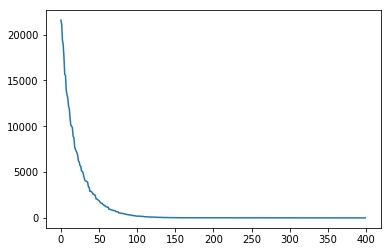

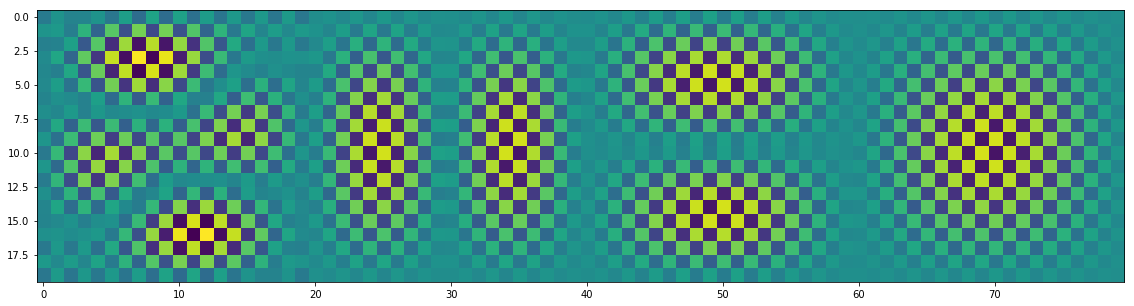

In [236]:

G = np.dot(X.T,X)

lam, vec = np.linalg.eigh(G)
sorted_indices = np.argsort(lam)[::-1]
lam = lam[sorted_indices]
vec = vec[:, sorted_indices].T
print vec.shape
plt.plot(lam)
plt.show()
img = np.concatenate( [v.reshape((n_,n_)) for v in vec[-5:-1] ], axis = 1)


plt.figure(figsize=(20,5))
plt.imshow(img)
plt.show()




In [199]:
AE = Autoencoder( [n, 50], transfer_function=tf.nn.relu, optimizer=tf.train.AdamOptimizer(0.01))
cost_ = 0

In [206]:
for epoch in range(20):
    cost = AE.partial_fit(X)
    print epoch, cost


0 63646.8
1 63639.6
2 63631.7
3 63624.3
4 63617.3
5 63610.5
6 63603.4
7 63596.7
8 63590.5
9 63583.7
10 63577.2
11 63570.4
12 63564.2
13 63557.7
14 63552.0
15 63545.8
16 63539.6
17 63533.7
18 63527.7
19 63522.3


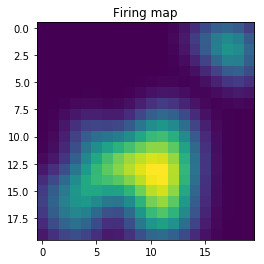

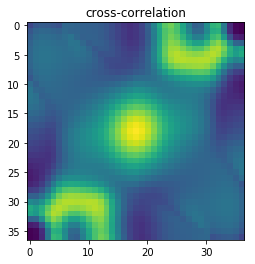

In [209]:
from htmresearch.support.gridcells.utils import (cross_correlate)
from scipy.special import expit as sigmoid
X_ = X[:]
Y = AE.transform(X_)
# W = AE.weights["encode"][0]["w"]
W = AE.getWeights(0)
# print W.shape


H = np.mean(Y[:,[10]]*X_, axis=0)

# H = np.dot(G, W[:,10]).reshape((n_,n_))



# plt.imshow(X_[1].reshape(n_,n_))
# plt.imshow( np.dot(G, W[:,0]).reshape((n_,n_)) )
# plt.show()

left  = H.reshape(n_,n_)
right = left
corr  = cross_correlate(left, right)

plt.title("Firing map")
plt.imshow(left)
plt.show()




plt.title("cross-correlation"); 
plt.imshow(corr)






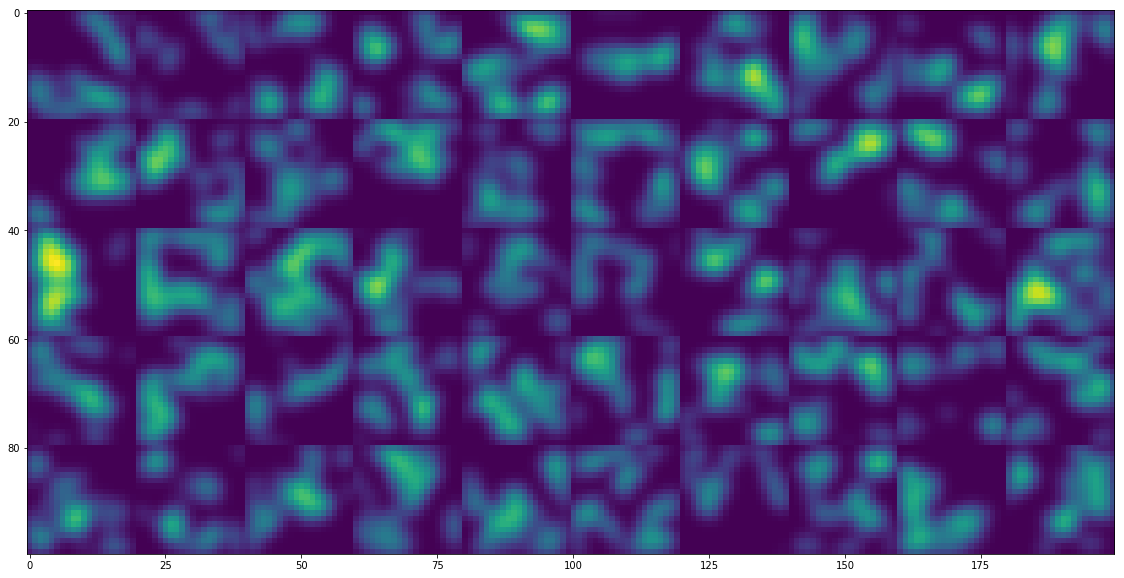

In [208]:

def create_corr_overview(Y, X, w, h, n_):
    H = np.zeros((w*h, X.shape[1]))
    for i in range(w*h):
        H[i] = np.mean(Y[:,[i]]*X, axis=0)
        
    img = np.zeros((w*n_, h*n_))
    for i in range(w):
        for j in range(h):
            H_ = H[j*w + i].reshape((n_,n_))
            img[i*n_:(i+1)*n_, j*n_:(j+1)*n_] = H_[:,:]
            
    return img.T
    

img = create_corr_overview(Y,X, 10, 5, n_)

plt.figure(figsize=(20,10))
plt.imshow(img)

    


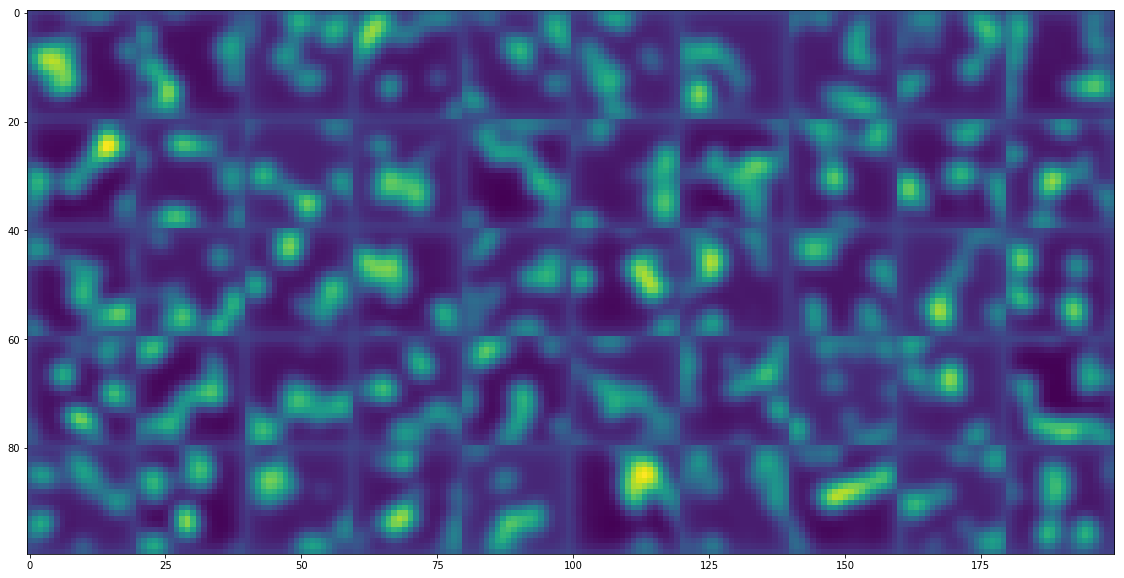

In [190]:
plt.figure(figsize=(20,10))
plt.imshow(img)